## Practical Example: Paired Convolutional Neural Networks as a Generative Adversarial Network (GAN)

The code implements a Generative Adversarial Network (GAN) using PyTorch and PyTorch Lightning, designed to generate realistic handwritten digit images mimicking the MNIST dataset. It comprises two main components: a Discriminator and a Generator. The Discriminator, a convolutional neural network (CNN), classifies images as real or fake, using convolutional layers for feature extraction, dropout for regularization, and pooling layers to reduce spatial dimensionality. The Generator, on the other hand, uses transposed convolutional layers to upscale a random noise vector into synthetic images, aiming to fool the Discriminator. Both networks train in tandem, with the Discriminator learning to better identify fake images, while the Generator improves at creating believable images. This adversarial training process is facilitated by PyTorch Lightning, which manages the training loops, data handling, and backpropagation, encapsulating the complex training logic while tracking training progress and visualizing results.

### Discriminator
The Discriminator is designed to classify images as real (from the MNIST dataset) or fake (generated by the Generator). It uses CNNs to effectively extract features from the input images through a series of convolutional layers and pooling operations:

<b> Convolutional Layers:</b> It contains two convolutional layers (conv1 and conv2). Each convolutional layer applies a set of filters to the input, which helps in capturing spatial hierarchies in the images. For example, the first layer might detect edges, while deeper layers could detect more complex patterns.

<b> Dropout Layer:</b>  After the second convolutional layer, a dropout layer (conv2_drop) is applied. This randomly sets a fraction of input units to zero during training, which helps prevent overfitting.

<b> Pooling:</b>  The output from each convolutional operation is passed through a max-pooling operation (F.max_pool2d), which reduces the spatial dimensions (height and width) of the input volume for the next layer. It helps in making the detection of features invariant to scale and orientation changes.

<b> Activation Function:</b> ReLU (Rectified Linear Unit) activation is used after each convolutional layer to introduce non-linearity into the model, allowing it to learn more complex patterns.

### Generator
The Generator in the GAN is tasked with generating new images from a random noise vector. It uses a form of CNN called "transposed convolutional networks" or "deconvolutional networks":

<b> Linear Layer:</b> Initially, a linear layer (lin1) transforms the input noise vector into a higher-dimensional space.

<b> Reshape: </b> The output of the linear layer is reshaped into a 3D volume to allow for convolutional operations.

<b> ConvTranspose Layers:</b> These are the core of the Generator. The ct1 and ct2 are transposed convolutional layers that upsample the input volume to a higher resolution. Transposed convolutions are often used in generative models to progressively increase the spatial resolution of the input volume to generate an output image.

<b> Final Convolution:</b> A final convolutional layer (conv) adjusts the number of output channels to match the desired number of output channels (in this case, 1, since MNIST images are grayscale). This layer shapes the final output to the size of MNIST images (28x28 pixels).

### Overall Use of CNN
In summary, the Discriminator uses traditional convolutional layers to perform feature extraction and classification, whereas the Generator uses transposed convolutional layers to perform the opposite task—generating realistic images from learned feature representations. This architecture leverages the spatial hierarchies learned by CNNs, making them particularly effective for image data like MNIST.

### GAN Model
GAN is a class derived from pl.LightningModule and it encapsulates the GAN's behavior.
- It includes methods for the forward pass, computing adversarial loss using binary cross-entropy, and configuring optimizers for both generator and discriminator.
- Custom training steps are defined for handling the training process, including backpropagation manually for each network.
- It captures metrics like loss and accuracy, stores generated images at each epoch, and finally plots these images to visualize the generator's progress over training.

### Training Process
- An instance of MNISTDataModule and GAN is created.
- A pl.Trainer is set up with specified parameters (like CPU usage and number of epochs) and used to train the model by passing the model and data module to it.
- The trainer handles the training iterations, calling the appropriate methods on the GAN instance for each batch of data.

### Utility Functions and Plotting
- The model includes functions to plot the evolution of generated images across epochs, and functions to record and plot various metrics such as discriminator and generator loss, accuracy, precision, and recall.
- These visualizations and metrics help in understanding how well the GAN is learning to generate realistic images over time.


<b> GPU Setup </b>

In [1]:
import torch
import tensorflow as tf
print(torch.backends.mps.is_available())  # Should return True
device = torch.device("mps")  # For Mac GPU
print(device)
x = torch.rand(3, 3).to(device)
print(x)
print("Num GPUs Available:", len(tf.config.experimental.list_physical_devices('GPU')))


True
mps
tensor([[0.5569, 0.1903, 0.4654],
        [0.0490, 0.2393, 0.1083],
        [0.4179, 0.5347, 0.3575]], device='mps:0')
Num GPUs Available: 1


In [4]:
# Import libraries

import os

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import MNIST
from sklearn.metrics import accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt
import pandas as pd

import pytorch_lightning as pl


random_seed = 42
torch.manual_seed(random_seed)

BATCH_SIZE=128
AVAIL_GPUS = min(1, torch.cuda.device_count())
NUM_WORKERS=int(os.cpu_count() / 2)

**Create a Class for managing MNIST data**

In [5]:
class MNISTDataModule(pl.LightningDataModule):
    def __init__(self, data_dir="./data", batch_size=32, num_workers=4):
        """
        Initialize the data module.

        Parameters:
        - data_dir (str): Directory to store the MNIST data.
        - batch_size (int): How many samples per batch to load.
        - num_workers (int): How many subprocesses to use for data loading.
        """
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_workers = num_workers

        # Define transformations to apply to each data item
        self.transform = transforms.Compose([
            transforms.ToTensor(),  # Convert images to PyTorch tensors
            transforms.Normalize((0.1307,), (0.3081,)),  # Normalize images using mean and std dev
        ])

    def prepare_data(self):
        """
        Download the MNIST dataset if it's not already available.
        """
        MNIST(self.data_dir, train=True, download=True)
        MNIST(self.data_dir, train=False, download=True)

    def setup(self, stage=None):
        """
        Prepare datasets for training, validation, and testing phases.

        Parameters:
        - stage (str): Current stage (fit or test)
        """
        if stage == "fit" or stage is None:
            mnist_full = MNIST(self.data_dir, train=True, transform=self.transform)
            self.mnist_train, self.mnist_val = random_split(mnist_full, [55000, 5000])
        if stage == "test" or stage is None:
            self.mnist_test = MNIST(self.data_dir, train=False, transform=self.transform)

    def train_dataloader(self):
        """
        Return the DataLoader for training data.
        """
        return DataLoader(self.mnist_train, batch_size=self.batch_size, num_workers=self.num_workers)

    def val_dataloader(self):
        """
        Return the DataLoader for validation data.
        """
        return DataLoader(self.mnist_val, batch_size=self.batch_size, num_workers=self.num_workers)

    def test_dataloader(self):
        """
        Return the DataLoader for testing data.
        """
        return DataLoader(self.mnist_test, batch_size=self.batch_size, num_workers=self.num_workers)

In [6]:

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 1)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return torch.sigmoid(x)

In [7]:
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.lin1 = nn.Linear(latent_dim, 7*7*64)  # [n, 256, 7, 7]
        self.ct1 = nn.ConvTranspose2d(64, 32, 4, stride=2) # [n, 64, 16, 16]
        self.ct2 = nn.ConvTranspose2d(32, 16, 4, stride=2) # [n, 16, 34, 34]
        self.conv = nn.Conv2d(16, 1, kernel_size=7)  # [n, 1, 28, 28]


    def forward(self, x):
        x = self.lin1(x)
        x = F.relu(x)
        x = x.view(-1, 64, 7, 7)  #256
        x = self.ct1(x)
        x = F.relu(x)
        x = self.ct2(x)
        x = F.relu(x)
        return self.conv(x)

In [8]:
class GAN(pl.LightningModule):
    def __init__(self, latent_dim=100, lr=0.0002, b1: float = 0.5, b2: float = 0.999):
        super().__init__()
        self.save_hyperparameters()
        self.generator = Generator(latent_dim=self.hparams.latent_dim)
        self.discriminator = Discriminator()
        self.validation_z = torch.randn(6, self.hparams.latent_dim)
        self.automatic_optimization = False
        self.epoch_images = []  # List to store images from each epoch
        self.metrics_df = pd.DataFrame(columns=['Epoch', 'd_loss', 'g_loss', 'd_acc', 'd_precision', 'd_recall'])
        self.training_step_outputs = []

    def forward(self, z):
        return self.generator(z)

    def adversarial_loss(self, y_hat, y):
        return F.binary_cross_entropy(y_hat, y)

    def configure_optimizers(self):
        opt_g = torch.optim.Adam(self.generator.parameters(), lr=self.hparams.lr, betas=(self.hparams.b1, self.hparams.b2))
        opt_d = torch.optim.Adam(self.discriminator.parameters(), lr=self.hparams.lr, betas=(self.hparams.b1, self.hparams.b2))
        return opt_g, opt_d

    def plot_epoch_images(self):
        # Calculate the number of rows and columns for subplots
        num_epochs = len(self.epoch_images)
        num_cols = min(num_epochs, 5)  # Limit the number of columns to 5
        num_rows = (num_epochs + num_cols - 1) // num_cols

        fig, axs = plt.subplots(num_rows, num_cols, figsize=(10, 2 * num_rows))
        axs = axs.flatten()  # Flatten to iterate easily

        for i, img in enumerate(self.epoch_images):
            axs[i].imshow(img[0].squeeze(), cmap='gray', interpolation='none')
            axs[i].set_title(f'Epoch {i+1}')
            axs[i].axis('off')

        # Hide any empty subplots if num_epochs is not divisible by num_cols
        for i in range(num_epochs, num_rows * num_cols):
            axs[i].axis('off')

        plt.tight_layout()  # Adjust subplot parameters for a tight layout
        plt.show()

    def on_epoch_end(self, real_imgs, fake_imgs, avg_g_loss, avg_d_loss):
        # Sample noise vector
        z = torch.randn(1, self.hparams.latent_dim, device=self.device)
        sample_image = self.generator(z).detach().cpu()
        self.epoch_images.append(sample_image)

        # Assuming real_imgs and fake_imgs are passed correctly from training_epoch_end
        valid = torch.ones(real_imgs.size(0), 1, device=self.device)
        fake = torch.zeros(fake_imgs.size(0), 1, device=self.device)

        real_preds = self.discriminator(real_imgs)
        fake_preds = self.discriminator(fake_imgs)
        real_acc = ((real_preds > 0.5).float() == valid).float().mean()
        fake_acc = ((fake_preds < 0.5).float() == fake).float().mean()
        d_acc = (real_acc + fake_acc) / 2
        d_precision = precision_score(valid.cpu(), (real_preds > 0.5).float().cpu(), zero_division=1)
        d_recall = recall_score(valid.cpu(), (real_preds > 0.5).float().cpu(), zero_division=1)

        self.metrics_df = pd.concat([self.metrics_df, pd.DataFrame([{
            'Epoch': self.current_epoch,
            'g_loss': avg_g_loss.item(),
            'd_loss': avg_d_loss.item(),
            'd_acc': d_acc.item(),
            'd_precision': d_precision,
            'd_recall': d_recall
        }])], ignore_index=True)


    def on_train_end(self):
        self.plot_epoch_images()  # Plot one image from each epoch
        self.metrics_df.to_csv('discriminator_metrics.csv', index=False)  # Save metrics DataFrame
        self.metrics_df.plot(x='Epoch', y=['d_loss', 'g_loss', 'd_acc', 'd_precision', 'd_recall'], kind='line', subplots=True, layout=(3, 2), figsize=(10, 10))  # Plot metrics
        plt.show()

    def on_train_epoch_end(self):
        # Access outputs from training_step using the Trainer's current_epoch attribute
        outputs = self.training_step_outputs
        avg_g_loss = torch.stack([x['g_loss'] for x in outputs]).mean()
        avg_d_loss = torch.stack([x['d_loss'] for x in outputs]).mean()

        # Assuming real_imgs and fake_imgs are stored in outputs
        last_output = outputs[-1]
        self.on_epoch_end(last_output['real_imgs'], last_output['fake_imgs'], avg_g_loss, avg_d_loss)

        # Clear outputs for the next epoch
        self.training_step_outputs.clear()  # Clear the list for the next epoch

    def training_step(self, batch, batch_idx):
        imgs, _ = batch
        z = torch.randn(imgs.shape[0], self.hparams.latent_dim, device=self.device)
        fake_imgs = self.generator(z)

        # Define 'valid' and 'fake' tensors
        valid = torch.ones(imgs.size(0), 1, device=self.device)
        fake = torch.zeros(imgs.size(0), 1, device=self.device)

        g_loss = self.adversarial_loss(self.discriminator(fake_imgs), valid)
        real_loss = self.adversarial_loss(self.discriminator(imgs), valid)
        fake_loss = self.adversarial_loss(self.discriminator(fake_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        self.manual_backward(g_loss)
        self.optimizers()[0].step()
        self.optimizers()[0].zero_grad()

        self.manual_backward(d_loss)
        self.optimizers()[1].step()
        self.optimizers()[1].zero_grad()

        # Only log metrics or return what's absolutely necessary
        # Accumulate outputs in a list
        self.training_step_outputs.append({'g_loss': g_loss.detach(), 'd_loss': d_loss.detach(), 'real_imgs': imgs, 'fake_imgs': fake_imgs})
        return {'g_loss': g_loss.detach(), 'd_loss': d_loss.detach(), 'real_imgs': imgs, 'fake_imgs': fake_imgs}
    
    def validation_step(self, batch, batch_idx):
        imgs, _ = batch
        z = torch.randn(imgs.shape[0], self.hparams.latent_dim, device=self.device)
        fake_imgs = self(z)
        real_loss = self.adversarial_loss(self.discriminator(imgs), torch.ones(imgs.size(0), 1, device=self.device))
        fake_loss = self.adversarial_loss(self.discriminator(fake_imgs), torch.zeros(imgs.size(0), 1, device=self.device))
        d_loss = (real_loss + fake_loss) / 2
        g_loss = self.adversarial_loss(self.discriminator(fake_imgs), torch.ones(imgs.size(0), 1, device=self.device))
        self.log('val_d_loss', d_loss, prog_bar=True)
        self.log('val_g_loss', g_loss, prog_bar=True)

    def test_step(self, batch, batch_idx):
        imgs, _ = batch
        z = torch.randn(imgs.shape[0], self.hparams.latent_dim, device=self.device)
        fake_imgs = self(z)
        real_loss = self.adversarial_loss(self.discriminator(imgs), torch.ones(imgs.size(0), 1, device=self.device))
        fake_loss = self.adversarial_loss(self.discriminator(fake_imgs), torch.zeros(imgs.size(0), 1, device=self.device))
        d_loss = (real_loss + fake_loss) / 2
        g_loss = self.adversarial_loss(self.discriminator(fake_imgs), torch.ones(imgs.size(0), 1, device=self.device))
        self.log('test_d_loss', d_loss)
        self.log('test_g_loss', g_loss)

In [9]:
dm = MNISTDataModule()
model = GAN()

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/benjaminwynia/anaconda3/lib/python3.11/site-packages/pytorch_lightning/trainer/configuration_validator.py:68: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.

  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | generator     | Generator     | 358 K  | train
1 | discriminator | Discriminator | 21.4 K | train
--------------------------------------------------------
379 K     Trainable params
0         Non-trainable params
379 K     Total params
1.520     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
/Users/benjaminwynia/anaconda3/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:420: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initi

Training: |                                               | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=60` reached.


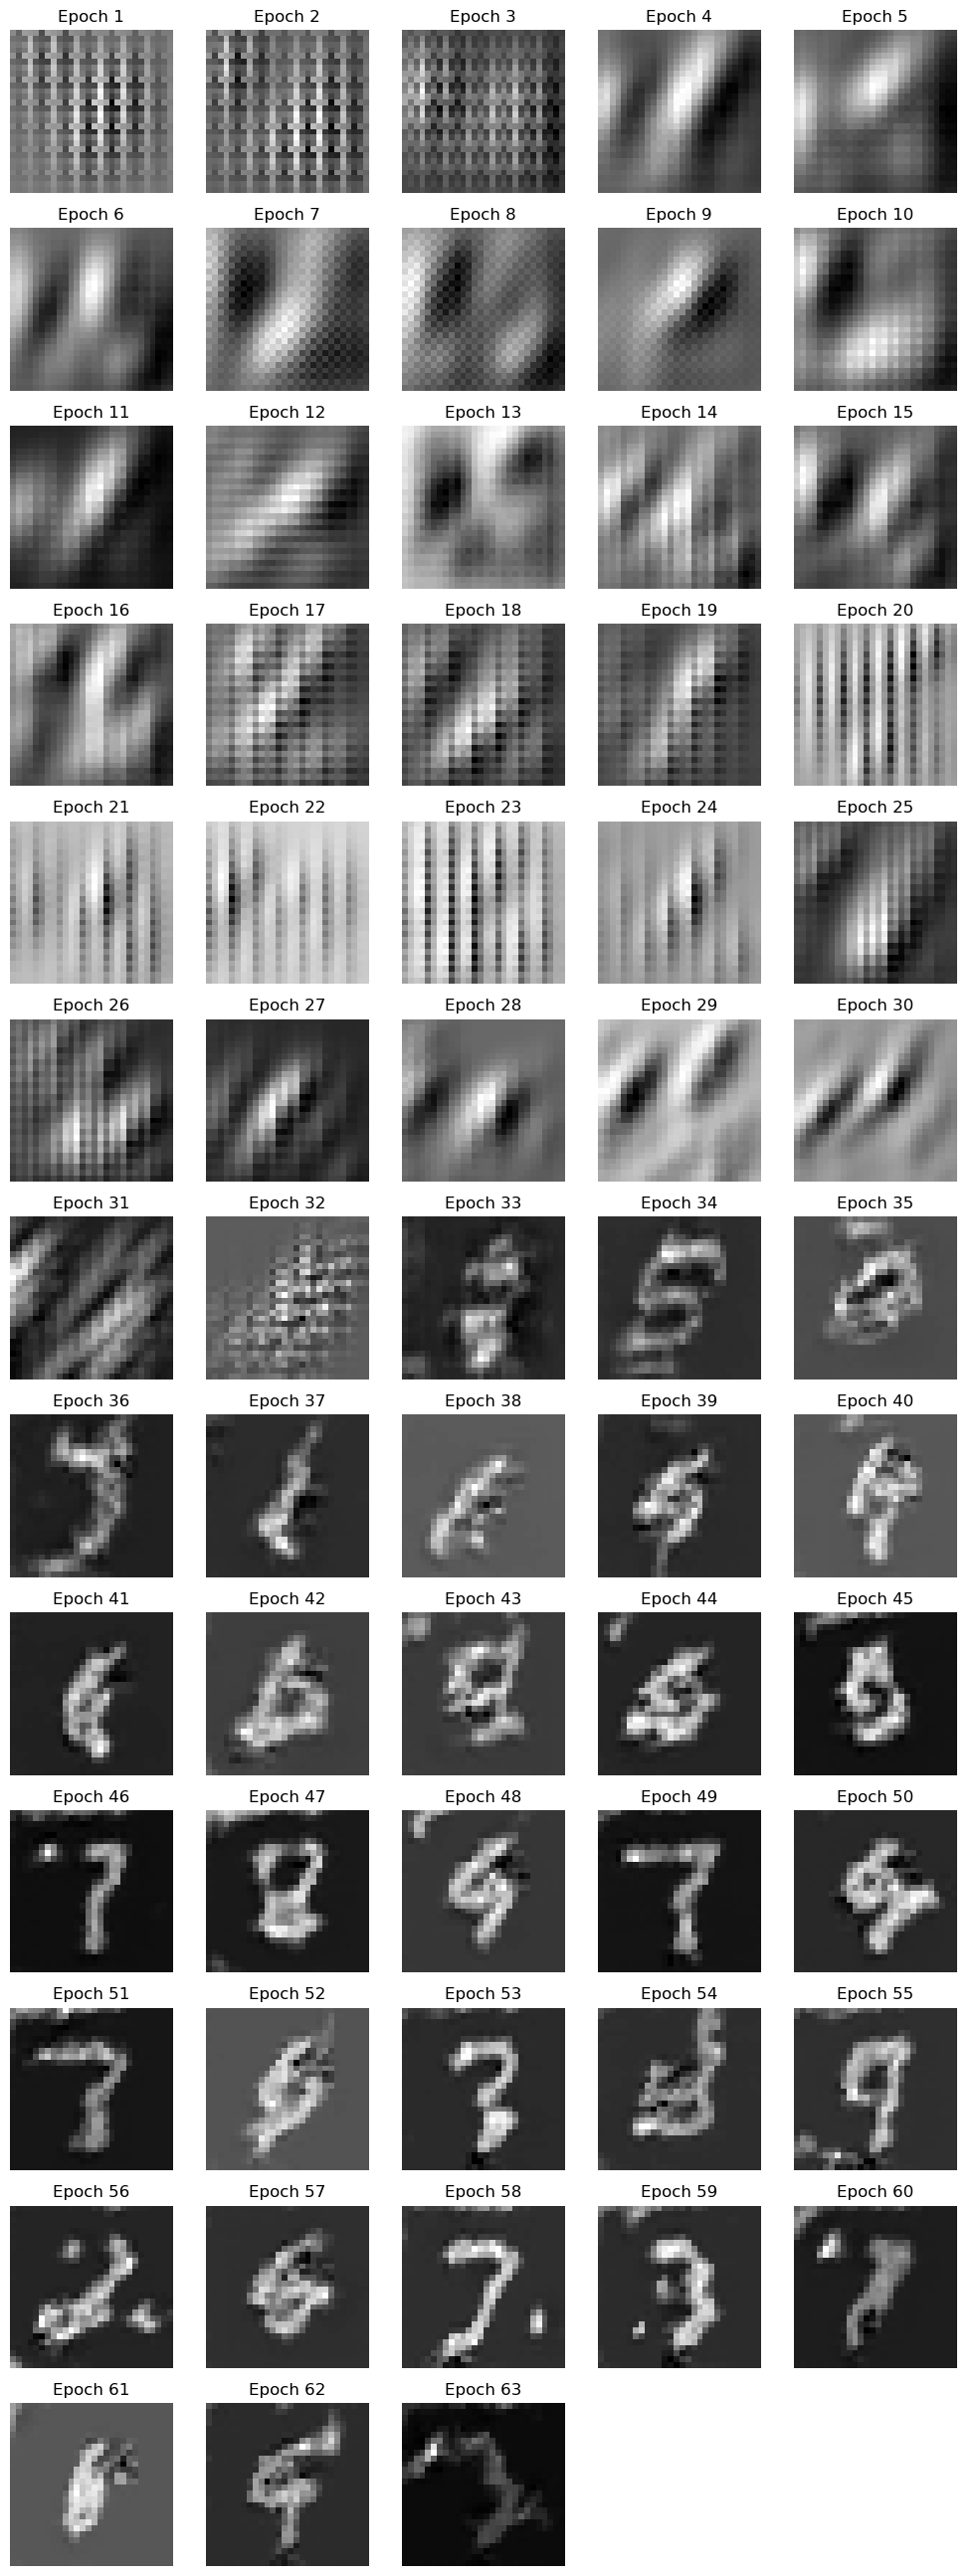

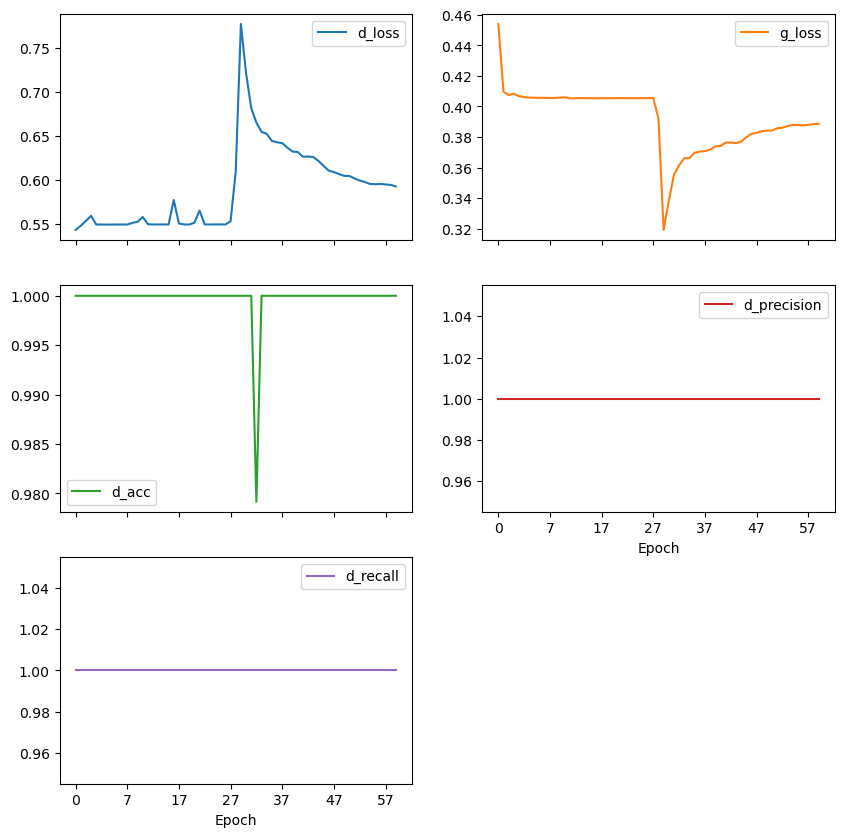

In [11]:
trainer = pl.Trainer(accelerator="mps", devices=1, max_epochs=60) # Replace 'gpus' with 'accelerator' and 'devices'
trainer.fit(model, dm)